# Tutorial: how to generate power-law surrogates


This notebook is designed briefly to illustrate generation of different types of power-law surrogates from synthetic data and an empirical time series.

## 0. Contents

**&nbsp;&nbsp;&nbsp;&nbsp;1. Import source code and basic libraries**

**&nbsp;&nbsp;&nbsp;&nbsp;2. Illustration using synthetic data**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1. Input sequence

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2. Estimating and applying the lower cut-off

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.3. Surrogate methods

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.4. Plotting: visually compare input sequence and surrogates

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.5. Hypothesis testing

**&nbsp;&nbsp;&nbsp;&nbsp;3. Illustration using empirical data**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1. Load empirical data from text file

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2. Estimating and applying the lower cut-off

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3. Make sequence shorter (for convenience)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.4. Plotting: visually compare input sequence and surrogates

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.5. Hypothesis testing

## 1. Import source code and basic libraries

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
# 
sys.path.append("./src/")
from constrained_power_law_surrogates import gen_typ_p_l_surrogate, gen_power_law_surr_list, ident_cut_off_const, plot_surr_seq, hypothesis_test, ks_stat, cond_ent_o_1, cond_ent_o_2

## 2. Illustration using synthetic data

### 2.1. Input sequence

Store your input sequence in the variable *seq*

Generate input sequence *seq* from a power-law with chosen exponent *gamma* and lower cut-off *x_min*:

In [2]:
gamma = 2; x_min = 3; N = 16;
seq = gen_typ_p_l_surrogate(gamma, x_min, N)
print(seq)

[4, 5, 3, 3, 6, 3, 7, 4, 19, 17, 3, 30, 6, 5, 8, 18]


### 2.2. Estimating and applying the lower cut-off

Estimate lower cut-off *x_min* by minimising KS-distance from maximum likelihood power-law

In [3]:
(x_min_KS, _, _, _, _) = ident_cut_off_const(seq)
print("Identified lower cut-off: " + str(x_min_KS))

Identified lower cut-off: 3


Divide input sequence *seq* into values *seq_L* below lower cut-off *x_min* and values *seq_U* greater than or equal to lower cut-off *x_min*

In [4]:
seq_L = [int(np.round(val)) for val in seq if val < x_min_KS]
print(seq_L)
seq_U = [int(np.round(val)) for val in seq if val >= x_min_KS]
print(seq_U)

[]
[4, 5, 3, 3, 6, 3, 7, 4, 19, 17, 3, 30, 6, 5, 8, 18]


### 2.3. Surrogate methods

Here are descriptions of the methods to generate (surrogate) time series:

In [5]:
surrogate_methods = ['obse','know','cons','typi','boot','shuf','mark','ordi']
method_description={
    'obse':'Original observation',
    'know':'Power-law surrogate with known scale exponent',
    'cons':'Constrained power-law surrogate',
    'typi':'Typical power-law surrogate',
    'boot':'Bootstrap surrogate',
    'shuf':'Shuffle surrogate',
    'mark':'Constrained Markov order power-law surrogate',
    'ordi':'Constrained ordinal pattern power-law surrogate'
}
method_names = {
    'obse':'Observed',
    'know': 'Known exponent',
    'cons':'Constrained',
    'typi':'Typical',
    'boot':'Bootstrapped',
    'shuf':'Shuffled',
    'mark':'Markov',
    'ordi':'Ordinal pattern'
}

You can choose one of the methods to generate the surrogate of the input sequence *seq* as follows:

In [6]:
print("Using sequence seq_U comprising values of input sequence above estimated lower cut-off x_min_KS=" + str(x_min_KS))
surr_seq_list = gen_power_law_surr_list(seq_U, surr_method='cons', x_min=x_min_KS)
print(surr_seq_list)

print("Using full input sequence seq and true lower cut-off x_min=" + str(x_min))
surr_seq_list = gen_power_law_surr_list(seq, surr_method='cons', x_min=x_min)
print(surr_seq_list)

Using sequence seq_U comprising values of input sequence above estimated lower cut-off x_min_KS=3
[[4, 5, 9, 3, 3, 6, 7, 4, 19, 408, 6, 5, 3, 5, 4, 3]]
Using full input sequence seq and true lower cut-off x_min=3
[[4, 5, 3, 24, 3, 3, 7, 16, 19, 51, 3, 15, 3, 5, 4, 3]]


Here are surrogates from all the methods:

In [7]:
for method in surrogate_methods:
    print("Using method: " + method + " to generate: " + method_description[method])
    if (method == 'know'):#Power-law surrogates with known scale exponent
        surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min, num_surr=2, scale_exp=2)#num_surr=2 independently realised surrogates, scale exponent 2
    elif (method == 'mark'):#Constrained Markov order power-law surrogate
        surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min, num_surr=2, o=1, b=3, num_trans=10**5)#num_surr=2 independently realised surrogates, Markov order o=1 using Markov states defined using bins of logarithmic length log(b) = log(3), Metropolis algorithm with num_trans=10**5 transitions
    elif (method == 'ordi'):#Constrained ordinal pattern power-law surrogate
        surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min, num_surr=2, L=16, num_trans=10**5)#num_surr=2 independently realised surrogates, Ordinal patterns of length L=16, Metropolis algorithm with num_trans=10**5 transitions
    else:
        surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min, num_surr=2)#num_surr=2 independently realised surrogates
    print(surr_seq_list,"\n")

Using method: obse to generate: Original observation
[[4, 5, 3, 3, 6, 3, 7, 4, 19, 17, 3, 30, 6, 5, 8, 18], [4, 5, 3, 3, 6, 3, 7, 4, 19, 17, 3, 30, 6, 5, 8, 18]] 

Using method: know to generate: Power-law surrogate with known scale exponent
[[169, 3, 3, 24, 4, 6, 4, 3, 3, 3, 6, 3, 37, 6, 6, 4], [4, 5, 10, 4, 3, 3, 62, 20, 3, 109, 3, 3, 19, 3, 3, 9]] 

Using method: cons to generate: Constrained power-law surrogate
[[4, 15, 9, 3, 3, 3, 14, 8, 76, 17, 3, 5, 3, 5, 4, 6], [16, 5, 3, 6, 9, 3, 7, 4, 19, 17, 9, 5, 3, 5, 16, 3]] 

Using method: typi to generate: Typical power-law surrogate
[[62, 3, 8, 8, 5, 15, 4, 6, 4, 10, 11, 5, 39, 7, 47, 3], [3, 7, 8, 19, 3, 4, 3, 4, 4, 5, 3, 8, 7, 4, 6, 31]] 

Using method: boot to generate: Bootstrap surrogate
[[3, 8, 3, 3, 30, 19, 17, 5, 19, 4, 5, 17, 3, 4, 3, 8], [3, 4, 3, 6, 3, 19, 17, 5, 3, 8, 7, 3, 3, 6, 30, 30]] 

Using method: shuf to generate: Shuffle surrogate
[[17, 6, 3, 6, 19, 5, 30, 5, 3, 7, 4, 8, 3, 4, 3, 18], [3, 18, 6, 7, 19, 6, 5, 4, 3, 

### 2.4. Plotting: visually compare input sequence and surrogates

Here is how to make plots comparing surrogates with the originally observed sequence:

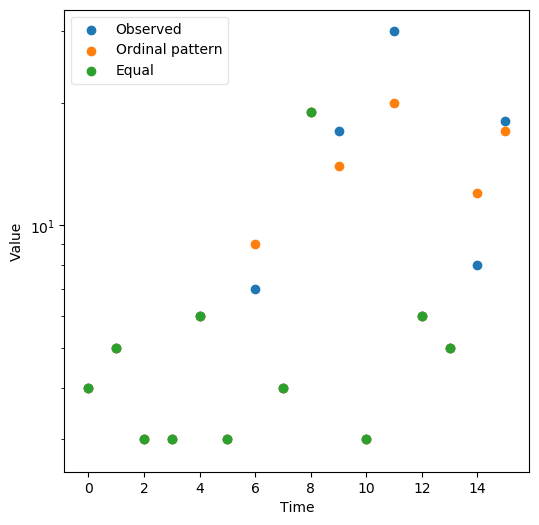

In [8]:
plot_surr_seq(surr_seq_list[0], obs_seq=seq, method_name=method_names[method], x_label='Time', y_label='Value')
plt.show()

### 2.5. Hypothesis testing

Perform hypothesis tests on short sequence *seq* of synthetic data:

In [9]:
quantile_list, p_val_left_tail_list, p_val_right_tail_list, p_val_two_tail_list = hypothesis_test(seq_U, method='typi', stat_func_list=[ks_stat, np.mean, max, cond_ent_o_2], num_surr=99)
# 
print('\n Outputs of the function "hypothesis_test":')
print("\t quantile_list=" + str(quantile_list))
print("\t p_val_left_tail_list=" + str(p_val_left_tail_list))
print("\t p_val_right_tail_list=" + str(p_val_right_tail_list))
print("\t p_val_two_tail_list=" + str(p_val_two_tail_list))

Using surrogate method: typi:
Equating lower cut-off parameter *x_min* with minimum value of argument *obs_seq*: x_min*=3
	 With statistic: ks_stat:
		 Quantile: 0.205
		 p-value for left-tailed test: 0.205
		 p-value for right-tailed test: 0.795
		 p-value for two-tailed test: 0.41
	 With statistic: mean:
		 Quantile: 0.405
		 p-value for left-tailed test: 0.405
		 p-value for right-tailed test: 0.595
		 p-value for two-tailed test: 0.81
	 With statistic: max:
		 Quantile: 0.335
		 p-value for left-tailed test: 0.335
		 p-value for right-tailed test: 0.665
		 p-value for two-tailed test: 0.67
	 With statistic: cond_ent_o_2:
		 Quantile: 0.135
		 p-value for left-tailed test: 0.135
		 p-value for right-tailed test: 0.865
		 p-value for two-tailed test: 0.27

 Outputs of the function "hypothesis_test":
	 quantile_list=[0.205, 0.405, 0.335, 0.135]
	 p_val_left_tail_list=[0.205, 0.405, 0.335, 0.135]
	 p_val_right_tail_list=[0.795, 0.595, 0.665, 0.865]
	 p_val_two_tail_list=[0.41, 0.81, 0.

## 3. Illustration using empirical data

### 3.1. Load empirical data from text file

Store your input sequence in the variable *seq*

Read input sequence *seq* from sequences of energy released by earthquakes:

In [10]:
seqtext = open("./time-series/energy.txt").read().split("\n")
seq = [int(x) for x in seqtext[:-1]]
print("Input sequence seq has length N=" + str(len(seq)))

Input sequence seq has length N=59555


### 3.2. Estimating and applying the lower cut-off

Estimate lower cut-off *x_min* by minimising KS-distance from maximum likelihood power-law:

In [11]:
(x_min, _, _, _, _) = ident_cut_off_const(seq)
print("Identified lower cut-off x_min=" + str(x_min))

Identified lower cut-off x_min=1


Discard elements of input sequence *seq* which lie below the estimated lower cut-off *x_min*:

In [12]:
seq = [int(np.round(val)) for val in seq if val >= x_min]
print("After discarding elements less than the estimated lower cut-off x_min = " + str(x_min) + ", input sequence seq has length N=" + str(len(seq)))

After discarding elements less than the estimated lower cut-off x_min = 1, input sequence seq has length N=59555


### 3.3. Make sequence shorter (for convenience)

Replace input sequence *seq* with a shorter subsequence:

In [13]:
N = 1024# Maximum length of time series
N0 = len(seq)
if (N0 >= N):
    start_point = random.randint(0, N0 - N)
    seq = seq[start_point:(start_point + N)]
else:
    N = N0

print("Considering N=" + str(N) + " elements starting from randomly chosen index " + str(start_point))
print("Input sequence seq has length N=" + str(len(seq)))

Considering N=1024 elements starting from randomly chosen index 46708
Input sequence seq has length N=1024


### 3.4. Plotting: visually compare input sequence and surrogates

Make plots comparing surrogates with the originally observed sequence of energy release by earthquakes：

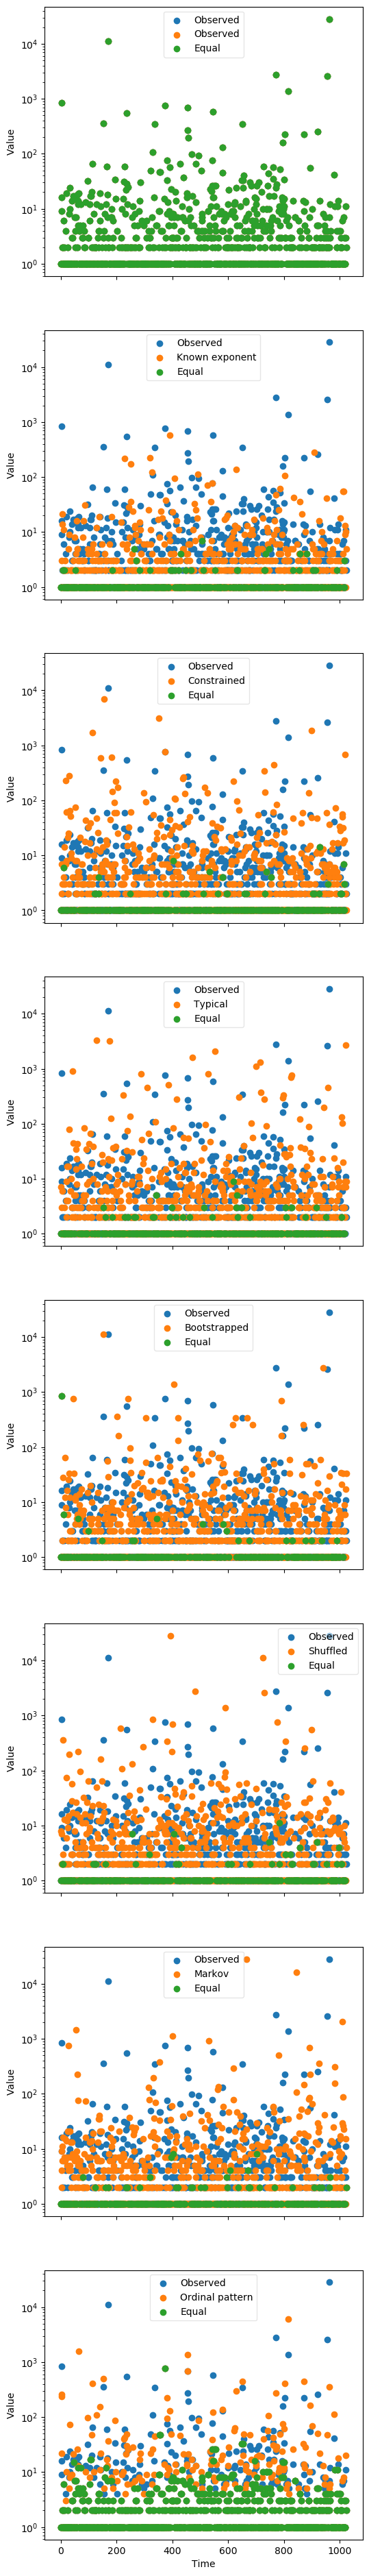

In [14]:
#Generate and plot realisation of each type of surrogate
num_surr_types = len(surrogate_methods)
fig, ax = plt.subplots(num_surr_types, 1, sharex='col', sharey='none', figsize=(6, 6*num_surr_types))
for i in range(num_surr_types):
    method = surrogate_methods[i]
    if (method == 'know'):#Power-law surrogates with known scale exponent
        surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min, scale_exp=2)#Scale exponent 2
    elif (method == 'mark'):#Constrained Markov order power-law surrogate
        surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min, o=1, b=3, num_trans=10**5)#Markov order o=1 using Markov states defined using bins of logarithmic length log(b) = log(3), Metropolis algorithm with num_trans=10**5 transitions
    elif (method == 'ordi'):#Constrained ordinal pattern power-law surrogate
        surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min, L=16, num_trans=10**5)#Ordinal patterns of length L=16, Metropolis algorithm with num_trans=10**5 transitions
    else:
        surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min)#
    surr_seq = surr_seq_list[0]
    ax_subplot = ax[i]
    plot_surr_seq(surr_seq, obs_seq=seq, method_name=method_names[method], ax=ax_subplot, x_label=None, y_label='Value')
ax[-1].set_xlabel('Time')
plt.show()

### 3.5. Hypothesis testing

Perform hypothesis tests on extract of energy released by earthquakes:

In [15]:
#Generate and plot realisation of each type of surrogate
stat_func_list = [ks_stat, np.mean, np.var, max, cond_ent_o_1, cond_ent_o_2]
num_surr_types = len(surrogate_methods)
fig, ax = plt.subplots(num_surr_types, 1, sharex='col', sharey='none', figsize=(6, 6*num_surr_types))
for i in range(num_surr_types):
    method = surrogate_methods[i]
    if (method == 'know'):#Power-law surrogates with known scale exponent
        quantile_list, p_val_left_tail_list, p_val_right_tail_list, p_val_two_tail_list = hypothesis_test(seq, method=method, stat_func_list=stat_func_list, num_surr=99, scale_exp=2)#Scale exponent 2
    elif (method == 'mark'):#Constrained Markov order power-law surrogate
        quantile_list, p_val_left_tail_list, p_val_right_tail_list, p_val_two_tail_list = hypothesis_test(seq, method=method, stat_func_list=stat_func_list, o=1, b=3, num_trans=10**5)#Markov order o=1 using Markov states defined using bins of logarithmic length log(b) = log(3), Metropolis algorithm with num_trans=10**5 transitions
    elif (method == 'ordi'):#Constrained ordinal pattern power-law surrogate
        quantile_list, p_val_left_tail_list, p_val_right_tail_list, p_val_two_tail_list = hypothesis_test(seq, method=method, stat_func_list=stat_func_list, L=16, num_trans=10**5)#Ordinal patterns of length L=16, Metropolis algorithm with num_trans=10**5 transitions
    else:
        quantile_list, p_val_left_tail_list, p_val_right_tail_list, p_val_two_tail_list = hypothesis_test(seq, method=method, stat_func_list=stat_func_list)#

Using surrogate method: obse:
Equating lower cut-off parameter *x_min* with minimum value of argument *obs_seq*: x_min*=1
	 With statistic: ks_stat:
		 Quantile: 0.775
		 p-value for left-tailed test: 0.775
		 p-value for right-tailed test: 0.22499999999999998
		 p-value for two-tailed test: 0.44999999999999996
	 With statistic: mean:
		 Quantile: 0.875
		 p-value for left-tailed test: 0.875
		 p-value for right-tailed test: 0.125
		 p-value for two-tailed test: 0.25
	 With statistic: var:
		 Quantile: 0.025
		 p-value for left-tailed test: 0.025
		 p-value for right-tailed test: 0.975
		 p-value for two-tailed test: 0.05
	 With statistic: max:
		 Quantile: 0.625
		 p-value for left-tailed test: 0.625
		 p-value for right-tailed test: 0.375
		 p-value for two-tailed test: 0.75
	 With statistic: cond_ent_o_1:
		 Quantile: 0.375
		 p-value for left-tailed test: 0.375
		 p-value for right-tailed test: 0.625
		 p-value for two-tailed test: 0.75
	 With statistic: cond_ent_o_2:
		 Quantile: 

		 Quantile: 0.625
		 p-value for left-tailed test: 0.625
		 p-value for right-tailed test: 0.375
		 p-value for two-tailed test: 0.75
	 With statistic: mean:
		 Quantile: 0.825
		 p-value for left-tailed test: 0.825
		 p-value for right-tailed test: 0.17500000000000004
		 p-value for two-tailed test: 0.3500000000000001
	 With statistic: var:
		 Quantile: 0.825
		 p-value for left-tailed test: 0.825
		 p-value for right-tailed test: 0.17500000000000004
		 p-value for two-tailed test: 0.3500000000000001
	 With statistic: max:
		 Quantile: 0.825
		 p-value for left-tailed test: 0.825
		 p-value for right-tailed test: 0.17500000000000004
		 p-value for two-tailed test: 0.3500000000000001
	 With statistic: cond_ent_o_1:
		 Quantile: 0.525
		 p-value for left-tailed test: 0.525
		 p-value for right-tailed test: 0.475
		 p-value for two-tailed test: 0.95
	 With statistic: cond_ent_o_2:
		 Quantile: 0.875
		 p-value for left-tailed test: 0.875
		 p-value for right-tailed test: 0.125
		 p-valu